In [321]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
from scipy import stats
import seaborn as sns
import talib as ta
from talib import RSI, BBANDS, MACD, ATR, MA, PPO
import warnings
from typing import List
import statsmodels.api as sm
from scipy.stats import spearmanr
import tqdm
from sklearn.ensemble import RandomForestRegressor
matplotlib.rcParams['figure.figsize'] = (15, 10)
warnings.filterwarnings('ignore')

# Read Data

In [2]:
try:
    os.chdir("../DataBase/files")
except FileNotFoundError:
    pass
!ls -a

.
..
.DS_Store
Archive
price_execution_data_list_16-08-2022-13-24-21.json
price_execution_data_list_16-08-2022-15-32-04.json
trade_book_data_16-08-2022-13-24-21.json
trade_book_data_16-08-2022-15-32-04.json


In [52]:
file_name = "price_execution_data_list"

def read_data_files(name_like: str):
    data_dict = {}
    for file_name in os.listdir():
        if name_like in file_name:
            data_dict[file_name] = pd.read_json(file_name)
    return data_dict

def aggregate_dict_to_dataframe(dictinary):
    df = pd.DataFrame()
    for key, val in dictinary.items():
        df = pd.concat([df, dictinary[key]], axis = 0)
    df.set_index("time", inplace=True)
    return df

price_execution_data = read_data_files(file_name)
price_execution_data_df = aggregate_dict_to_dataframe(price_execution_data)


del price_execution_data

price_execution_data_df = price_execution_data_df.sort_index()

In [280]:
price_execution_data_df.head()

,time,symbol,price,delta_time,return,price_forward,return_forward
0,1.660649e+09,BTCUSDT,24071.40,0.611654,-0.000013,24076.39,-0.000010
1,1.660649e+09,BTCUSDT,24072.47,1.330175,0.000044,24076.43,0.000002
2,1.660649e+09,BTCUSDT,24073.85,0.592218,0.000057,24077.94,0.000063
3,1.660649e+09,BTCUSDT,24072.48,0.634877,-0.000057,24077.11,-0.000034
4,1.660649e+09,BTCUSDT,24073.51,0.613495,0.000043,24076.65,-0.000019


In [54]:
price_execution_data_df["return"] = price_execution_data_df.price.pct_change()

In [55]:
price_execution_data_df["price_forward"] = price_execution_data_df.price.shift(-13)
price_execution_data_df["return_forward"] = price_execution_data_df.price.pct_change().shift(-13)
price_execution_data_df.dropna(inplace=True)

train_size = int(0.7*price_execution_data_df.shape[0])
price_execution_data_df.reset_index(inplace=True)
data_train, data_test = price_execution_data_df.iloc[:train_size], price_execution_data_df.iloc[train_size:]

print(data_train.shape)
print(data_test.shape)

(13990, 7)
(5996, 7)


In [56]:
data_train.head()

,time,symbol,price,delta_time,return,price_forward,return_forward
0,1.660649e+09,BTCUSDT,24071.40,0.611654,-0.000013,24076.39,-0.000010
1,1.660649e+09,BTCUSDT,24072.47,1.330175,0.000044,24076.43,0.000002
2,1.660649e+09,BTCUSDT,24073.85,0.592218,0.000057,24077.94,0.000063
3,1.660649e+09,BTCUSDT,24072.48,0.634877,-0.000057,24077.11,-0.000034
4,1.660649e+09,BTCUSDT,24073.51,0.613495,0.000043,24076.65,-0.000019


# Feature Enginerring

## Shifted Returns

In [57]:
def create_shift_price(series: pd.Series, shift_val):
    return series.shift(shift_val)

In [367]:
data_train[f"return{1}_back"] = create_shift_price(data_train["return"], 0)
for i in range(1,6):
    data_train[f"return{13*i}_back"] = create_shift_price(data_train["return"], 13*i)
    data_test[f"return{13*i}_back"] = create_shift_price(data_test["return"], 13*i)

6.272063853772178e-05

## Moving Average Returns

In [68]:
for i in range(1,6):
    data_train[f"MA_{13*i}_returns"] = MA(data_train["price"], 13*i).pct_change()
    data_test[f"MA_{13*i}_returns"] = MA(data_test["price"], 13*i).pct_change()

/var/folders/1c/_rrq92wn6fd1bb8_8yd4_kcr0000gn/T/ipykernel_2281/295471118.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train[f"MA_{13*i}_returns"] = MA(data_train["price"], 13*i).pct_change()


## RSI

In [81]:
data_train["RSI"] = RSI(data_train["price"])
data_test["RSI"] = RSI(data_test["price"])

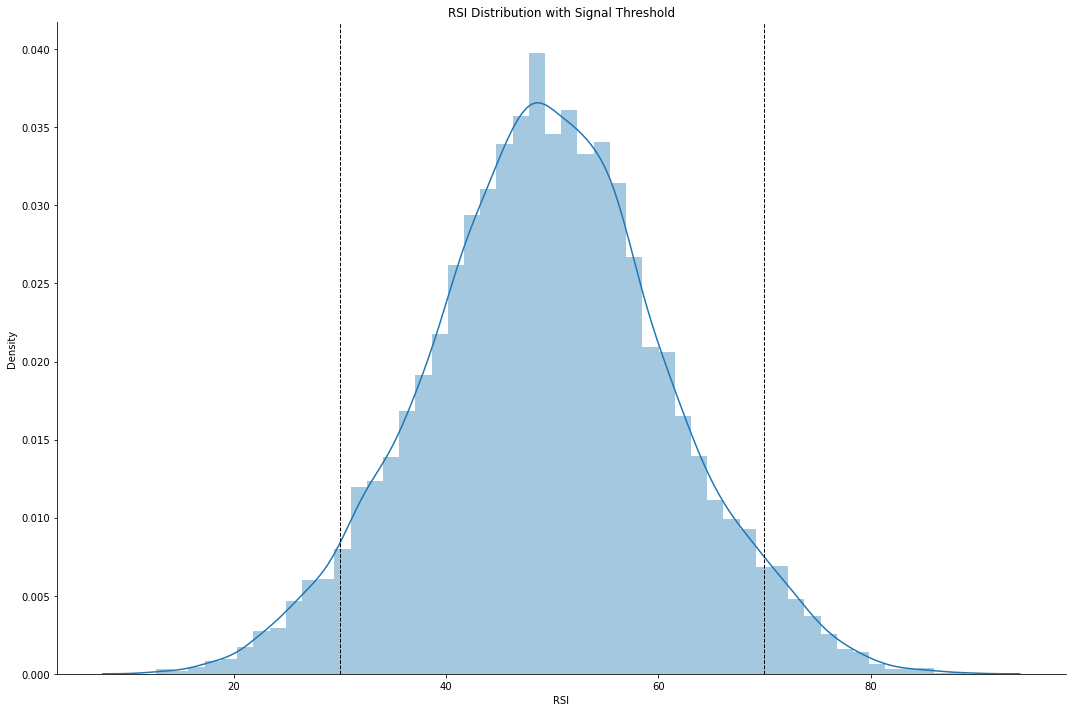

In [83]:
ax = sns.distplot(data_train["RSI"].dropna())
ax.axvline(30, ls='--', lw=1, c='k')
ax.axvline(70, ls='--', lw=1, c='k')
ax.set_title('RSI Distribution with Signal Threshold')
sns.despine()
plt.tight_layout();

## Bolinger Bands on Returns

In [109]:
high, mid, low = BBANDS(data_train["price"], timeperiod=13)

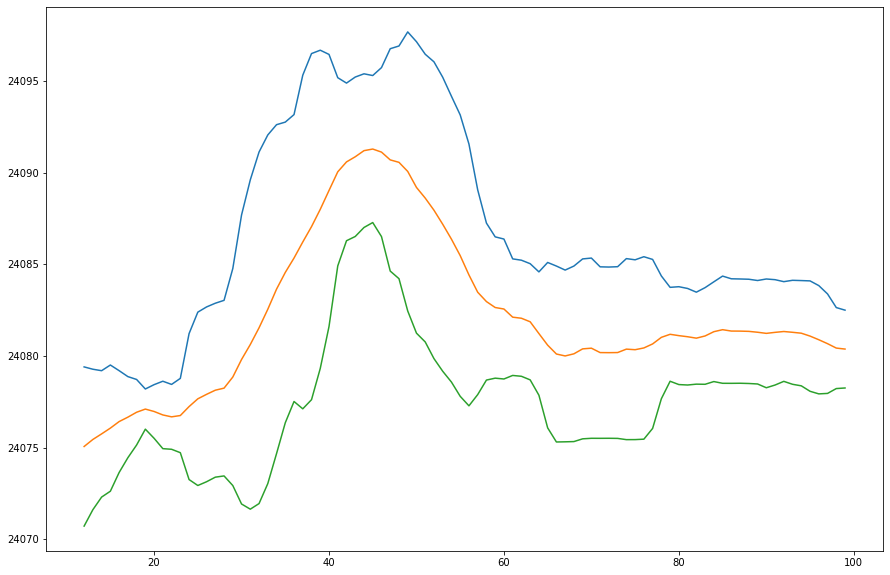

In [110]:
plt.plot(high[:100])
plt.plot(mid[:100])
plt.plot(low[:100])

In [111]:
for i in range(1,6):
    high, mid, low = BBANDS(data_train["price"], timeperiod=13*i)
    data_train[f"BB_high_{13*i}_returns"] = high.pct_change()
    data_train[f"BB_low_{13*i}_returns"] = low.pct_change()
    data_test[f"BB_high_{13*i}_returns"] = data_test.pct_change()
    data_test[f"BB_low_{13*i}_returns"] = data_test.pct_change()

## Moving Average Convergence/Divergence

In [122]:
data_train["PPO"] = PPO(data_train["price"])
data_test["PPO"] = PPO(data_test["price"])

<AxesSubplot:>

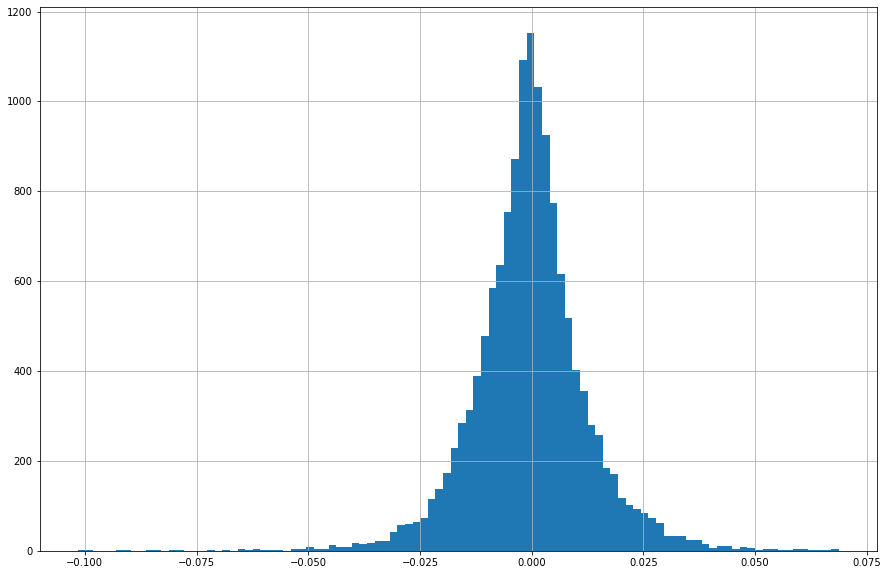

In [124]:
data_train["PPO"].hist(bins = 100)

In [132]:
def compute_macd(price):
    macd = MACD(price)[0]
    return (macd - np.mean(macd))/np.std(macd)
data_train["MACD"] = compute_macd(data_train["price"])
data_test["MACD"] = compute_macd(data_test["price"])

## Compute rolling quantiles

In [161]:
def compute_quantile(series, quantile_val):
    return series.quantile(quantile_val)

In [166]:
low_quantile = 0.01
high_quantile = 0.99
for i in range(1,5):
    data_train[f"quantile_{i*13}_{low_quantile}"] = data_train["return"].rolling(i*13).apply(lambda x: compute_quantile(x, low_quantile))
    data_train[f"quantile_{i*13}_{high_quantile}"] = data_train["return"].rolling(i*13).apply(lambda x: compute_quantile(x, high_quantile))
    
    data_test[f"quantile_{i*13}_{low_quantile}"] = data_test["return"].rolling(i*13).apply(lambda x: compute_quantile(x, low_quantile))
    data_test[f"quantile_{i*13}_{high_quantile}"] = data_test["return"].rolling(i*13).apply(lambda x: compute_quantile(x, high_quantile))

## Compute rolling volatility

In [167]:
def compute_vol(series):
    return series.std()

In [168]:
for i in range(1,5):
    data_train[f"vol_{i*13}"] = data_train["return"].rolling(i*13).apply(lambda x: compute_vol(x))
    data_test[f"vol_{i*13}"] = data_test["return"].rolling(i*13).apply(lambda x: compute_vol(x))

# Data Visulisation

In [253]:
data_train = data_train.dropna()
data_test = data_test.dropna()

data_train.index = data_train.time
data_test.index = data_test.time

In [284]:
feature_name = list(data_train.columns[7:])
target = [data_train.columns[6]]
print(target)
print(feature_name)

['return_forward']
['return13_back', 'return26_back', 'return39_back', 'return52_back', 'return65_back', 'MA_13_returns', 'MA_26_returns', 'MA_39_returns', 'MA_52_returns', 'MA_65_returns', 'RSI', 'BB_high_13_returns', 'BB_low_13_returns', 'BB_high_26_returns', 'BB_low_26_returns', 'BB_high_39_returns', 'BB_low_39_returns', 'BB_high_52_returns', 'BB_low_52_returns', 'BB_high_65_returns', 'BB_low_65_returns', 'PPO', 'MACD', 'quantile_13_0.01', 'quantile_13_0.99', 'quantile_26_0.01', 'quantile_26_0.99', 'quantile_39_0.01', 'quantile_39_0.99', 'quantile_52_0.01', 'quantile_52_0.99', 'vol_13', 'vol_26', 'vol_39', 'vol_52']


## Descriptive Statistics

In [270]:
data_train[feature_name].describe()

,return13_back,return26_back,return39_back,return52_back,return65_back,MA_13_returns,MA_26_returns,MA_39_returns,MA_52_returns,MA_65_returns,...,quantile_26_0.01,quantile_26_0.99,quantile_39_0.01,quantile_39_0.99,quantile_52_0.01,quantile_52_0.99,vol_13,vol_26,vol_39,vol_52
count,1.392500e+04,1.392500e+04,1.392500e+04,1.392500e+04,1.392500e+04,1.392500e+04,1.392500e+04,1.392500e+04,1.392500e+04,1.392500e+04,...,13925.000000,13925.000000,13925.000000,13925.000000,13925.000000,13925.000000,13925.000000,13925.000000,13925.000000,13925.000000
mean,-5.994318e-07,-6.116267e-07,-5.737586e-07,-6.166934e-07,-6.225414e-07,-5.881607e-07,-5.989614e-07,-5.931647e-07,-5.900062e-07,-5.952677e-07,...,-0.000161,0.000157,-0.000177,0.000172,-0.000186,0.000181,0.000075,0.000077,0.000078,0.000078
std,8.398939e-05,8.398937e-05,8.387857e-05,8.384198e-05,8.380099e-05,2.254616e-05,1.549123e-05,1.207670e-05,1.020445e-05,9.184398e-06,...,0.000102,0.000074,0.000104,0.000073,0.000103,0.000071,0.000038,0.000034,0.000032,0.000031
min,-1.171671e-03,-1.171671e-03,-1.171671e-03,-1.171671e-03,-1.171671e-03,-1.664296e-04,-9.757303e-05,-6.799223e-05,-5.359188e-05,-4.738652e-05,...,-0.001030,0.000029,-0.000986,0.000034,-0.000941,0.000050,0.000013,0.000018,0.000021,0.000026
25%,-3.990848e-05,-3.990848e-05,-3.989266e-05,-3.992403e-05,-3.990848e-05,-1.206611e-05,-8.715554e-06,-6.872283e-06,-5.969398e-06,-5.501378e-06,...,-0.000193,0.000102,-0.000215,0.000118,-0.000225,0.000128,0.000050,0.000054,0.000055,0.000056
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-7.351668e-07,-7.195270e-07,-5.986840e-07,-4.981117e-07,-4.574078e-07,...,-0.000142,0.000142,-0.000154,0.000161,-0.000162,0.000173,0.000067,0.000070,0.000071,0.000071
75%,3.772078e-05,3.771712e-05,3.767308e-05,3.761752e-05,3.761208e-05,1.044291e-05,7.563528e-06,5.865118e-06,4.938497e-06,4.324732e-06,...,-0.000102,0.000199,-0.000115,0.000209,-0.000125,0.000217,0.000093,0.000093,0.000093,0.000093
max,6.694357e-04,6.694357e-04,6.694357e-04,6.694357e-04,6.694357e-04,1.337008e-04,8.325837e-05,5.801117e-05,6.375317e-05,5.038669e-05,...,-0.000031,0.000619,-0.000038,0.000592,-0.000050,0.000566,0.000418,0.000351,0.000314,0.000282


## Pair Analysis on Sample

In [278]:
sns.pairplot(data_train[feature_name + target].iloc[:1000])

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7ff4eba4ab90> (for post_execute):


KeyboardInterrupt: 

## Pearson Correlation in Between Features

<AxesSubplot:>

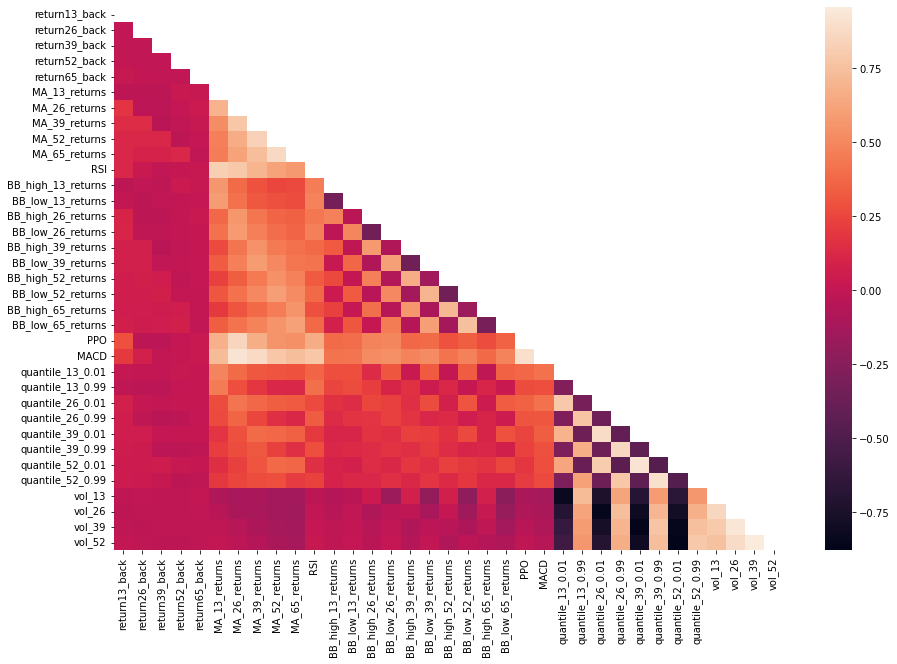

In [255]:
corr = data_train[feature_name].corr(method='pearson')
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask = mask)

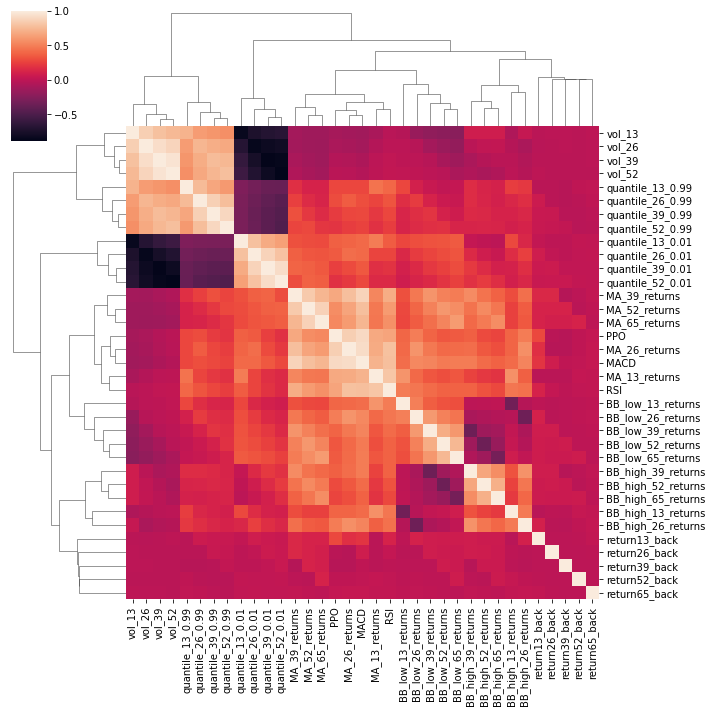

In [238]:
sns.clustermap(data_train[feature_name].corr())

## Pearson Correlation Features vs Target

<AxesSubplot:>

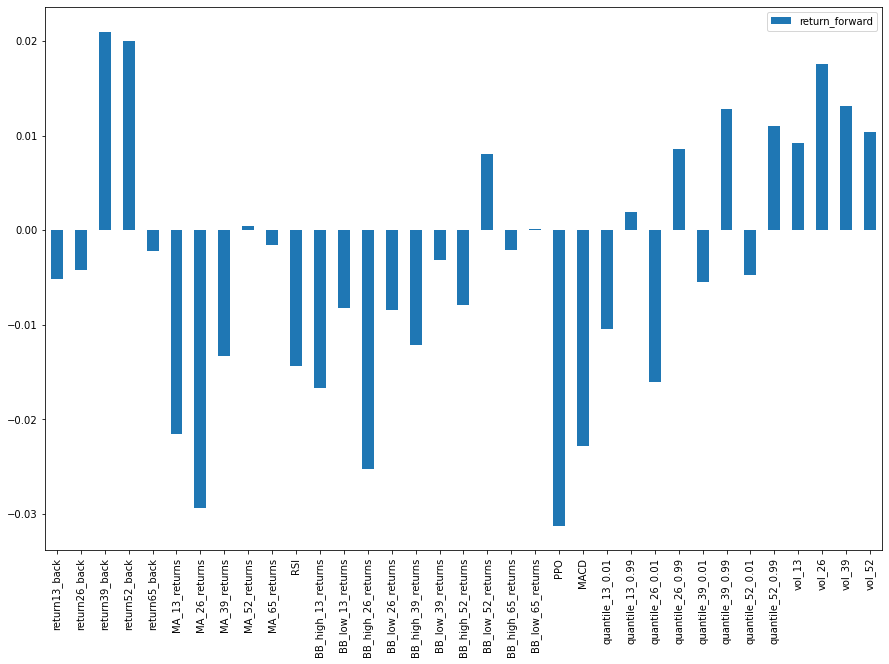

In [256]:
corr = data_train[feature_name + target].corr(method='pearson')
corr[target].iloc[:-1].plot.bar()

## Statistical inference with Linear Regression
**violating mutural colinearity in between features

In [263]:
lr = sm.OLS(data_train[target],data_train[feature_name])
res = lr.fit()

In [264]:
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:         return_forward   R-squared (uncentered):                   0.004
Model:                            OLS   Adj. R-squared (uncentered):              0.002
Method:                 Least Squares   F-statistic:                              1.766
Date:                Mon, 22 Aug 2022   Prob (F-statistic):                     0.00350
Time:                        19:29:12   Log-Likelihood:                      1.1095e+05
No. Observations:               13925   AIC:                                 -2.218e+05
Df Residuals:                   13890   BIC:                                 -2.216e+05
Df Model:                          35                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

In [ ]:
plt.plot(res.resid)

# Modelling

This Notebook won't focus a lot on hyper paramter tuning, the goal is only to find a hypothetical model which is able to generate certain information based on features

## Establish Metric and Baseline Model

In [286]:
# Spearman Correlation will be used as Information Cofficient generated by model as metric
def ic_metric(y_true, y_pred):
    return spearmanr(y_true, y_pred)[0]

In [311]:
def base_line_model_maringale(current_return):
    """
    E[X_(t+1)|F_t]=X_t
    """
    return current_return

In [288]:
print(ic_metric(data_train["return_forward"], base_line_model_maringale(data_train["return"])))

-0.007226426373488548


In [306]:
ic_baseline = []
rolling_window = 13 * 100 # On AVERAGE every 13 data points comes within 10 second interval
start_index = 0
end_index = start_index + rolling_window
while end_index <= data_train.shape[0]:
    y_true = data_train["return_forward"].iloc[start_index:end_index]
    y_pred = base_line_model_maringale(data_train["return"].iloc[start_index:end_index])
    ic_baseline.append(ic_metric(y_true, y_pred))
    start_index+=1
    end_index = start_index + rolling_window

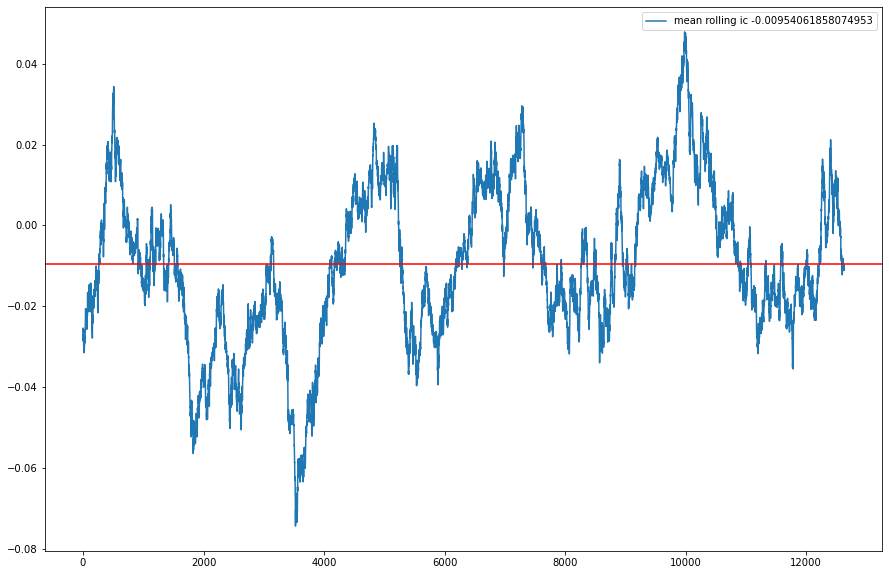

In [310]:
plt.plot(ic_baseline, label = f"mean rolling ic {np.mean(ic_baseline)}")
plt.axhline(np.mean(ic_baseline),c="red")
plt.legend()

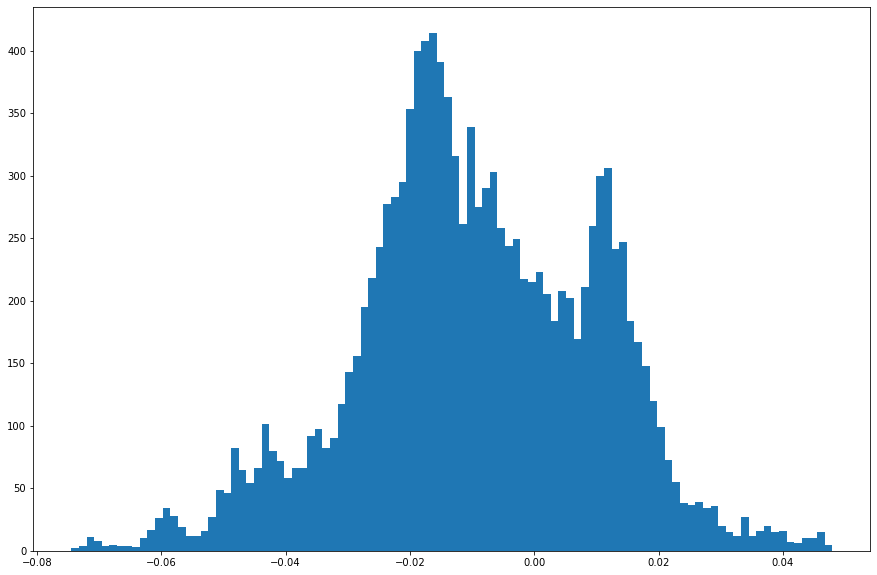

count    12627.000000
mean        -0.009541
std          0.019358
min         -0.074444
25%         -0.021279
50%         -0.010516
75%          0.005161
max          0.047934
dtype: float64


In [374]:
plt.hist(ic_baseline, bins = 100)
plt.show()
print(pd.Series(ic_baseline).describe())

## Random Forest 1

This implimentation using fixed look back period

In [327]:
train_score = []
val_score = []
look_back_period = 1000 # IS A HYPERPARAMETR which requires tuning
validate_period = 100
start_index = 0
end_index = start_index + look_back_period 
# while end_index <= data_train.shape()[0]:
# won't use all the data just for POC reasons
for i in tqdm.tqdm(range(1000)):
    X_train, y_train = data_train[feature_name].iloc[start_index:end_index], data_train[target].iloc[start_index:end_index]
    X_val, y_val = data_train[feature_name].iloc[end_index:end_index+validate_period], data_train[target].iloc[end_index:end_index+validate_period]
    model = RandomForestRegressor(n_estimators=100,
                                   max_depth=10,
                                   max_features=0.8,
                                   n_jobs=-1)
    model.fit(X_train,y_train)
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    train_score.append(ic_metric(y_train,y_pred_train))
    val_score.append(ic_metric(y_val,y_pred_val))
    start_index=+1 #the lower the value the more time it would require to fit model
    end_index = start_index + look_back_period 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:04<00:00,  4.09it/s]


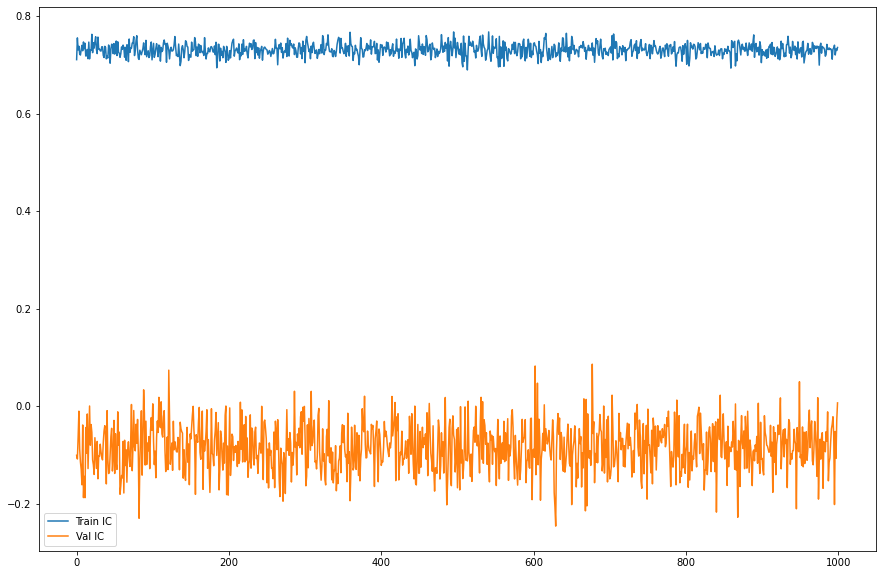

In [332]:
plt.plot(train_score, label="Train IC")
plt.plot(val_score, label="Val IC")
plt.legend()

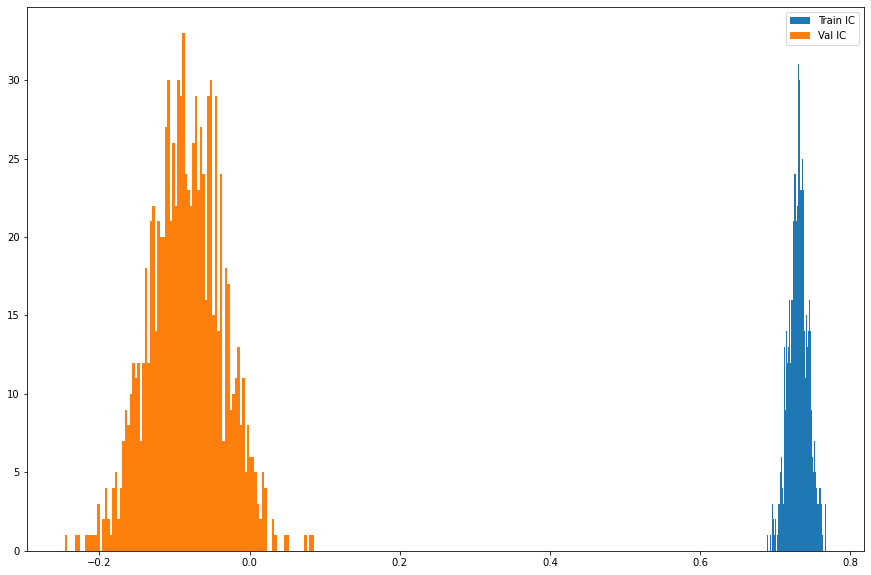

In [333]:
plt.hist(train_score,bins = 100, label="Train IC")
plt.hist(val_score,bins = 100, label="Val IC")
plt.legend()

## Random Forest 2

This implimentation using all avaiable samples at each iteration (from 0 to end_index)

will ading more samples improve the result?

In [343]:
num_observation = []
train_score = []
val_score = []
look_back_period = 1000 # IS A HYPERPARAMETR which requires tuning
validate_period = 100
start_index = 0
end_index = start_index + look_back_period 
# while end_index <= data_train.shape()[0]:
# won't use all the data just for POC reasons
for i in tqdm.tqdm(range(1000)):
    X_train, y_train = data_train[feature_name].iloc[0:end_index], data_train[target].iloc[0:end_index]
    X_val, y_val = data_train[feature_name].iloc[end_index:end_index+validate_period], data_train[target].iloc[end_index:end_index+validate_period]
    model = RandomForestRegressor(n_estimators=100,
                                   max_depth=10,
                                   max_features=0.8,
                                   n_jobs=-1)
    model.fit(X_train,y_train)
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    train_score.append(ic_metric(y_train,y_pred_train))
    val_score.append(ic_metric(y_val,y_pred_val))
    num_observation.append(end_index)
    end_index = end_index + 10 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [16:11<00:00,  1.03it/s]


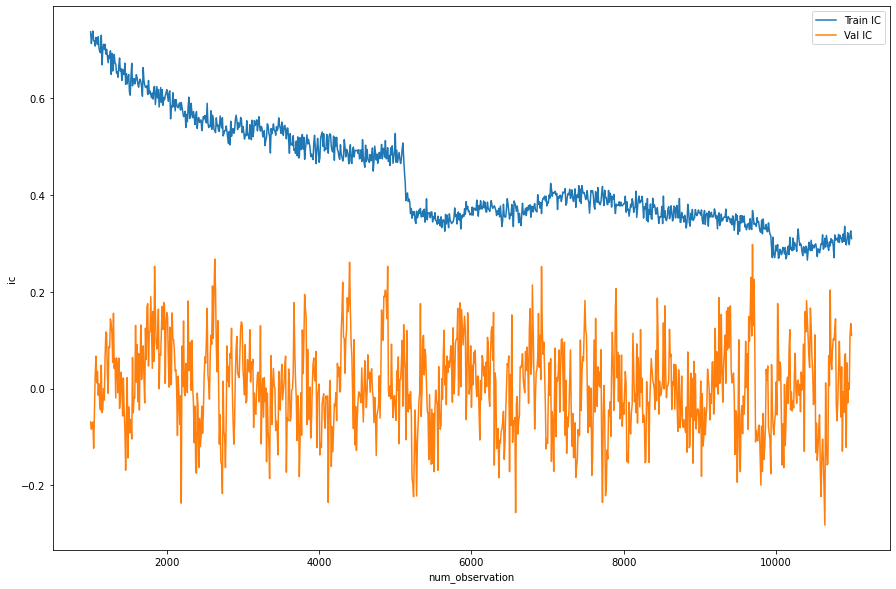

In [351]:
plt.plot(num_observation, train_score, label="Train IC")
plt.plot(num_observation, val_score, label="Val IC")
plt.xlabel("num_observation")
plt.ylabel("ic")
plt.legend()

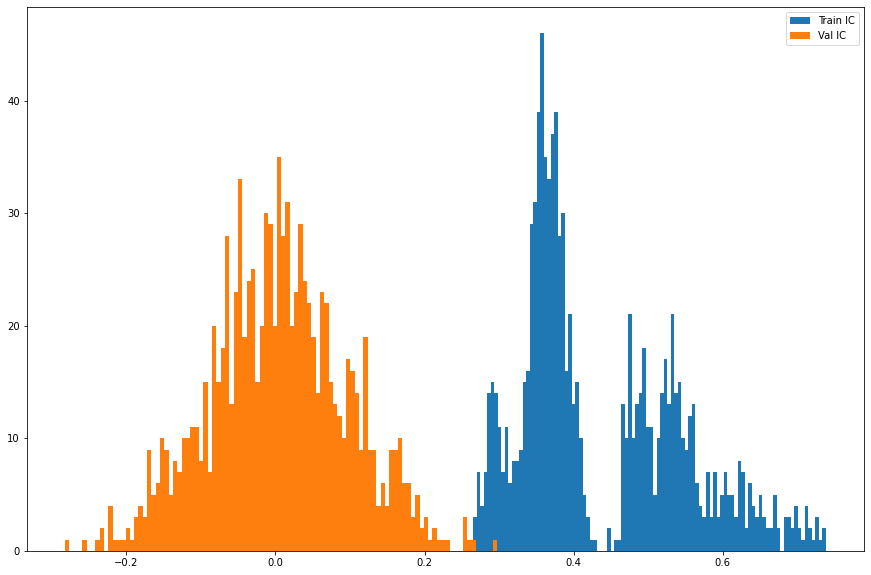

In [345]:
plt.hist(train_score,bins = 100, label="Train IC")
plt.hist(val_score,bins = 100, label="Val IC")
plt.legend()

In [361]:
pd.Series(train_score).describe()

count    1000.000000
mean        0.436075
std         0.109861
min         0.265213
25%         0.354593
50%         0.387953
75%         0.523303
max         0.738241
dtype: float64

In [362]:
pd.Series(val_score).describe()

count    1000.000000
mean        0.003596
std         0.092228
min        -0.282148
25%        -0.056166
50%         0.003243
75%         0.064962
max         0.297618
dtype: float64

<AxesSubplot:xlabel='feature_name'>

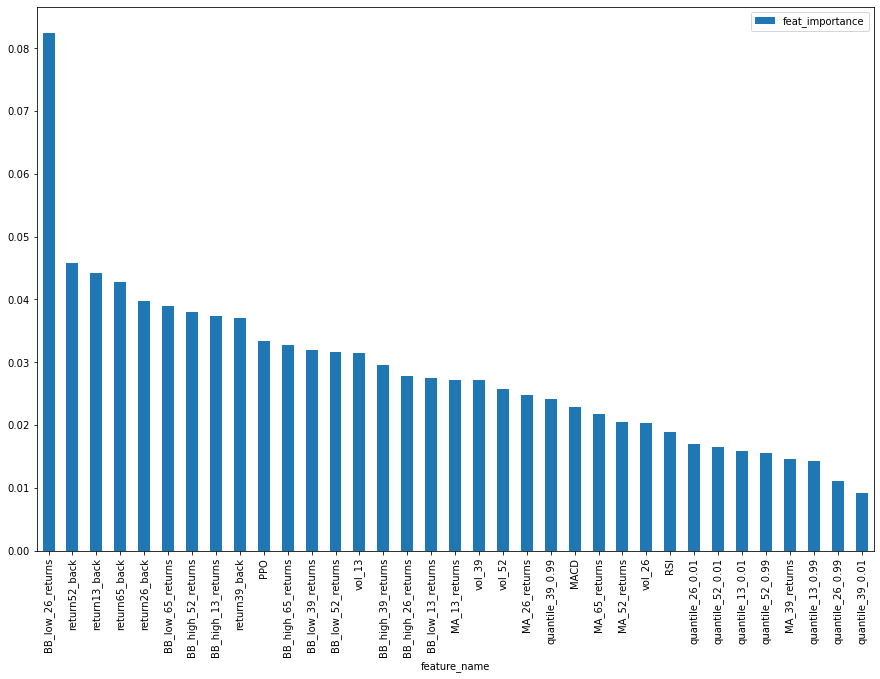

In [360]:
(
    pd.DataFrame({"feat_importance": model.feature_importances_,
                  "feature_name": data_train[feature_name].columns})
    .sort_values(by="feat_importance", ascending=False).plot.bar(x="feature_name", y ="feat_importance")
)

## Boosting